# Iniciando análise unitária
### Anaĺise baseado em um único paciente

In [1]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import os

PATH = os.path.abspath('../../')

df = pd.read_csv(PATH+'/data/Generalized_seizures_dataset.csv')

## Estratégia para pegar dados de pacientes individualmente

### Decompondo path

In [2]:
parts = [path.split("/") for path in df['path'].to_list()]

patients = []
sessions = []
files = []

for item in df['path'].to_list():
    part = item.split("/")
    patients.append(part[-3])
    sessions.append(part[-2])
    files.append(part[-1].replace('tse','edf'))

df['patients'] = patients
df['sessions'] = sessions
df['files'] = files

In [3]:
unique_patients = np.unique(patients)

### Carregando dados de paciente

In [4]:
import mne 

# Função para carregar edf's
def load_edf(path):
    path_folder = '/media/davi/2526467b-9f07-4ce5-9425-6d2b458567b7/home/davi/www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.2/edf/'
    file = path.replace('tse', 'edf')
    data = mne.io.read_raw_edf(path_folder + file)
    info = data.info
    return {"info": info, "data": data, "file": file.split('/')[-1]}


In [5]:
paciente = unique_patients[0]

data_paciente = df[df['patients'] == paciente].reset_index(drop=True)

In [ ]:
edfs = Parallel(n_jobs=-1) \
        (delayed(load_edf) \
        (item) for item in data_paciente['path'].unique())

### Organizando dados de paciente

In [7]:
# Freq amostral
freq = np.unique([item["info"]['sfreq'] for item in edfs])[0].astype(int)

# Canais do EDF
ch = np.unique([item["info"]['ch_names'] for item in edfs])

# Canal de ECG
ecg_ch = [i for i in ch if 'EKG' in i][0]

In [8]:
def set_labels(df_, file, info):
    
    fs = int(info['sfreq'])

    periods = df[df['files']==file].loc[:,['inicio','fim']].astype({"inicio":int, "fim": int})
    periods = periods.apply(lambda x: x*fs).reset_index(drop=True)

    # COM CRISE = 1 -> yes
    # SEM CRISE = 0 -> not
    df_['labels'] = np.repeat('not',len(df_))
    df_['file'] = np.repeat(file,len(df_))

    for index ,row in periods.iterrows():
        df_.loc[row['inicio']:row['fim'],'labels'] = np.repeat('yes',(row['fim']-row['inicio'])+1)  
    
    return df_

def raw2df(raw, file, info):
    df_ =  raw.to_data_frame()
    return set_labels(df_, file, info)


signals = Parallel(n_jobs=-1) \
                (delayed(raw2df) \
                (edf['data'],edf['file'], edf['info']) for edf in edfs)


In [9]:
signals = pd.concat(signals).reset_index(drop=True)

## Pipeline para extração de características

In [10]:
arq = signals['file'].unique()[0]

ecg_not = signals[(signals.file==arq) & (signals.labels=='not')].reset_index(drop=True)[ecg_ch]

ecg_yes = signals[(signals.file==arq) & (signals.labels=='yes')].reset_index(drop=True)[ecg_ch]


In [62]:
x = ecg_yes.to_numpy()*(-1)

In [60]:
from scipy import signal, io


def ecg_filter(ecg_raw,fs):
    Ts = 1/fs   # Sampling period [s].
    gain = 100  # Gain [u.a.]    
    f_nyquist = fs / 2
    # Time vector.
    t = np.arange(0, len(ecg_raw)*Ts, Ts)
    #%% Define execution parameters.
    delta_t = 40e-3 # Suggested value is 40e-3 (p. 50) [s]
    delta_t_n = delta_t * fs # [samples]
    #%% Pre-process data.
    # Convert to mV.
    ecg_mV = ecg_raw / gain     # [mV]
    #%% Filter ECG (as suggested in the paper).
    # Filter parameters.
    n = 8 # Desired (effective) order.
    f_low = 0.5 # Cut-off frequency 1 (suggested value is 0.5) [Hz]
    f_high = 45 # Cut-off frequency 2 (suggested value is 45) [Hz]
    b, a = signal.butter(round(n/2), [f_low/f_nyquist, f_high/f_nyquist], btype='band')
    # Actual filtering.
    ecg_pre = signal.filtfilt(b, a, ecg_mV) # [mV]
    return ecg_pre, ecg_mV, t

def get_rpeaks(ecg_pre,fs):
    delta_t = 40e-3 # Suggested value is 40e-3 (p. 50) [s]
    delta_t_n = delta_t * fs # [samples]
    peak_threshold = 0.7;
    r_peaks, r_peaks_prop = signal.find_peaks(ecg_pre, height=peak_threshold, distance=delta_t_n)
    return r_peaks, r_peaks_prop
    
def ecg_segmented_beat_modulation_noise_removal(ecg, fs, r_peaks, delta_t=40e-3):
    
    delta_t_n = delta_t * fs
    
    n_beats = len(r_peaks)
                
    rr_intervals = np.diff(r_peaks)
    mCCd = round(np.median(rr_intervals)) # [samples]
    
    mTUPd = mCCd - 2*delta_t_n # Median length of TUP segment [samples]

    cc = r_peaks - delta_t_n
    
    # Cast to int.
    cc = cc.astype(int)
    
    cc_segmentation = list()
    qrs_segments = list()
    tup_segments = list()
    tup_segments_modulated = list()
    cc_modulated = list()
    for ii in range(0, n_beats-1):
        cc_segmentation.append(ecg[cc[ii]:cc[ii+1]])
        qrs_segments.append(cc_segmentation[ii][0:int(delta_t_n*2)])
        tup_segments.append(cc_segmentation[ii][int(delta_t_n*2):])

        try:
            # Modulate TUP segments.
            tup_segments_modulated.append(signal.resample(tup_segments[ii], int(mTUPd)))
            # Cardiac cycle reconstruction.
            cc_modulated.append(np.concatenate((qrs_segments[ii], tup_segments_modulated[ii])))
        except (ValueError, IndexError):
            continue
        
    mCC = np.median(cc_modulated, 0)
     
    #%% Clean ECG extraction (Fig. 4)
    
    # mCC segmentation.
    qrs_segment_median = mCC[0:int(delta_t_n*2)]
    tup_segment_median = mCC[int(delta_t_n*2):]
    
    # Demodulate tup_segment_median.
    tup_segments_demodulated = list()
    cc_demodulated = list()
    for ii in range(0, n_beats-1):
        tup_segments_demodulated.append(signal.resample(tup_segment_median, len(tup_segments[ii])))
        cc_demodulated.append(np.concatenate((qrs_segment_median, tup_segments_demodulated[ii])))

    # Cardiac cycle concatenation.
    ecg_clean = [item for sublist in cc_demodulated for item in sublist]

    return (ecg_clean, mCC, cc_modulated)

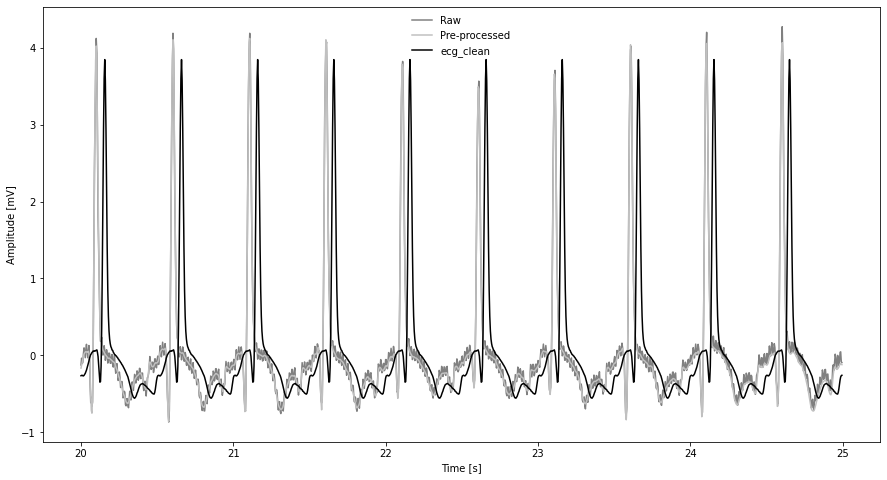

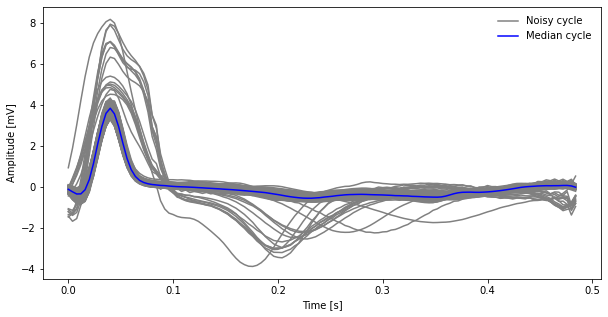

In [68]:
import matplotlib.pyplot as plt 

Ts = 1/freq

ecg_pre, ecg_mV, t = ecg_filter(x,freq)

# ecg_for_peaks = ecg_pre[freq*20:freq*40]
# t_peaks = np.arange(0, len(ecg_for_peaks)*Ts, Ts)

# r_peaks, r_peaks_prop = get_rpeaks(ecg_for_peaks,freq)

r_peaks, r_peaks_prop = get_rpeaks(ecg_pre,freq)

(ecg_clean, mCC, cc_modulated) = ecg_segmented_beat_modulation_noise_removal(
    ecg_pre, 
    freq, 
    r_peaks);
# fig = plt.figure(figsize=(10,7))

fig, ax = plt.subplots(1, 1, figsize=[15, 8])
plt.plot(t[freq*20:freq*25], ecg_mV[freq*20:freq*25], color='gray')
plt.plot(t[freq*20:freq*25], ecg_pre[freq*20:freq*25], color='silver')
plt.plot(t[freq*20:freq*25], ecg_clean[freq*20:freq*25], color='black')

ax.legend(["Raw", "Pre-processed","ecg_clean"], frameon=False)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude [mV]")


t_mCC = np.arange(0, len(mCC)*Ts, Ts)
    
fig, ax = plt.subplots(1, 1, figsize=[10, 5])
for ii, cc_modulated_ in enumerate(cc_modulated):
    if ii == 1:
        line_legend = "Noisy cycle"
    else:
        line_legend = None
    plt.plot(t_mCC, cc_modulated_, color='gray', label=line_legend)
plt.plot(t_mCC, mCC, color='blue', label="Median cycle")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude [mV]")
# ax.set_ylim([-0.75, 1.25])
ax.legend(frameon=False)
# fig.savefig(PATH_IMAGES/'ecg_template.png', dpi=1000, bbox_inches='tight')

# fig, ax = plt.subplots(1, 1, figsize=[10, 5])
# plt.plot(t_peaks, list(ecg_for_peaks), color='black')
# plt.plot(r_peaks*Ts, r_peaks_prop['peak_heights'], 'or',color='orange')
# ax.legend(["ECG", "Peaks"], frameon=False)
# ax.set_xlabel("Time [s]")
# ax.set_ylabel("Amplitude [mV]")




In [73]:
def ecg_pipeline(signal, freq):
    ecg_pre, ecg_mV, t = ecg_filter(signal,freq)
    r_peaks, r_peaks_prop = get_rpeaks(ecg_pre,freq)
    ecg_clean, mCC, cc_modulated = ecg_segmented_beat_modulation_noise_removal(ecg_pre, freq, r_peaks)
    return {
        "ecg_clean":ecg_clean,
        "r_peaks":r_peaks, 
        "mCC":mCC, 
        "cc_modulated":cc_modulated
        }

{'ecg_clean': [-0.11979833591448714,
  -0.24042547528138075,
  -0.3484374791057231,
  -0.3417867956272459,
  -0.1411980411258782,
  0.3533925956283956,
  1.140848727310005,
  2.0863518762762947,
  2.9500344855805416,
  3.5978562656527533,
  3.8447411514967955,
  3.569163032474297,
  2.947693737446614,
  2.1485471618300362,
  1.3943997538588868,
  0.8431959745832128,
  0.509671136278091,
  0.3166995176280999,
  0.21219706985950784,
  0.15167234428442655,
  0.11447921234583279,
  0.09874612204341315,
  0.06808048975092926,
  0.0683897642437656,
  0.04186609183025908,
  0.03341196823857711,
  0.0123374650291828,
  0.010562389554959192,
  -0.0022269889994805422,
  -0.004504646729601216,
  -0.01853442298263942,
  -0.024289595033560867,
  -0.0394272094841937,
  -0.04805032099804882,
  -0.06138039557813493,
  -0.07201531711200143,
  -0.08219069021045973,
  -0.09550155108934422,
  -0.10548365671147214,
  -0.12230545485951495,
  -0.1299750717389016,
  -0.14610121055575534,
  -0.1571814922003765

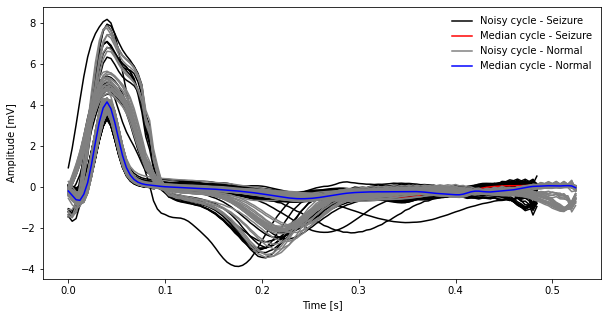

In [79]:
ecg1 = ecg_yes.to_numpy()*(-1)
ecg2 = ecg_not.to_numpy()*(-1)

d1 = ecg_pipeline(ecg1,freq)
d2 = ecg_pipeline(ecg2,freq)


Ts = 1/freq

t_mCC_1 = np.arange(0, len(d1['mCC'])*Ts, Ts)
t_mCC_2 = np.arange(0, len(d2['mCC'])*Ts, Ts)

    
fig, ax = plt.subplots(1, 1, figsize=[10, 5])

for ii, cc_modulated_ in enumerate(d1['cc_modulated']):
    if ii == 1:
        line_legend = "Noisy cycle - Seizure"
    else:
        line_legend = None
    plt.plot(t_mCC_1, cc_modulated_, color='black', label=line_legend)
plt.plot(t_mCC_1, d1['mCC'], color='red', label="Median cycle - Seizure")

for ii, cc_modulated_ in enumerate(d2['cc_modulated']):
    if ii == 1:
        line_legend = "Noisy cycle - Normal"
    else:
        line_legend = None
    plt.plot(t_mCC_2, cc_modulated_, color='gray', label=line_legend)
plt.plot(t_mCC_2, d2['mCC'], color='blue', label="Median cycle - Normal")

ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude [mV]")
# ax.set_ylim([-0.75, 1.25])
ax.legend(frameon=False)

d1


In [ ]:
d1[]

In [246]:
from scipy.signal import find_peaks, butter, filtfilt

# x = ecg_raw.to_numpy().T[0]
fs = 256
delta_t = 40e-3 
Ts = 1/fs   # Sampling period [s].
gain = 100
f_nyquist = fs / 2
delta_t_n = delta_t * fs

# Time vector.
t = np.arange(0, len(x)*Ts, Ts)

ecg_mV = x/gain 
# Filter parameters.
n = 8 # Desired (effective) order.
f_low = 0.5 # Cut-off frequency 1 (suggested value is 0.5) [Hz]
f_high = 45 # Cut-off frequency 2 (suggested value is 45) [Hz]
# When creating the filter, we will divide the order by 2.

# This is because we will be doing forward and backward filtering later on.
# Thus, we wish to keep the original filter specification.
b, a = butter(round(n/2), [f_low/f_nyquist, f_high/f_nyquist], btype='band')

# Actual filtering.
ecg_pre = filtfilt(b, a, ecg_mV) # [mV]

# Find R peaks.
# Here, we will use a simple thresholding operation.
# However, there are better (i.e., more robust) ways to do so.
peak_threshold = 0.8;
r_peaks, r_peaks_prop = find_peaks(ecg_pre, height=peak_threshold, distance=delta_t_n)


(ecg_clean, mCC, cc_modulated) = ecg_segmented_beat_modulation_noise_removal(
                                                            ecg_pre,
                                                            freq,
                                                            r_peaks)


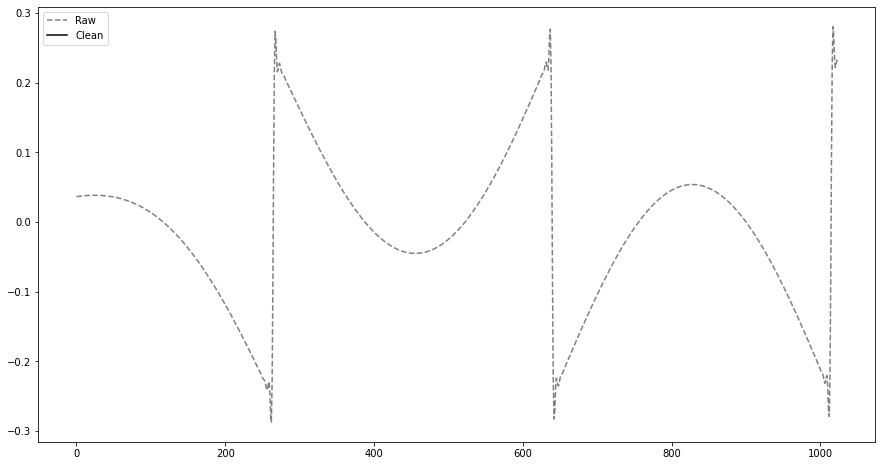

In [247]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=[15, 8])

ecg_clean2 = np.full_like(ecg_mV, np.nan)
ecg_clean2[int(r_peaks[0]-delta_t_n):int(r_peaks[0]-delta_t_n+len(ecg_clean))] = ecg_clean

plt.plot(ecg_pre[:256*4], '--',color='gray',label='Raw')
# plt.plot(ecg_mV[:256*4],color='black',label='Pre-processed')
plt.plot(ecg_clean2[:256*4],color='black',label='Clean')
plt.legend()